# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [153]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
from matplotlib import pyplot as plt # type: ignore
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [154]:
df = pd.read_csv('bikes_rent.csv')
print(df.head(5))      

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

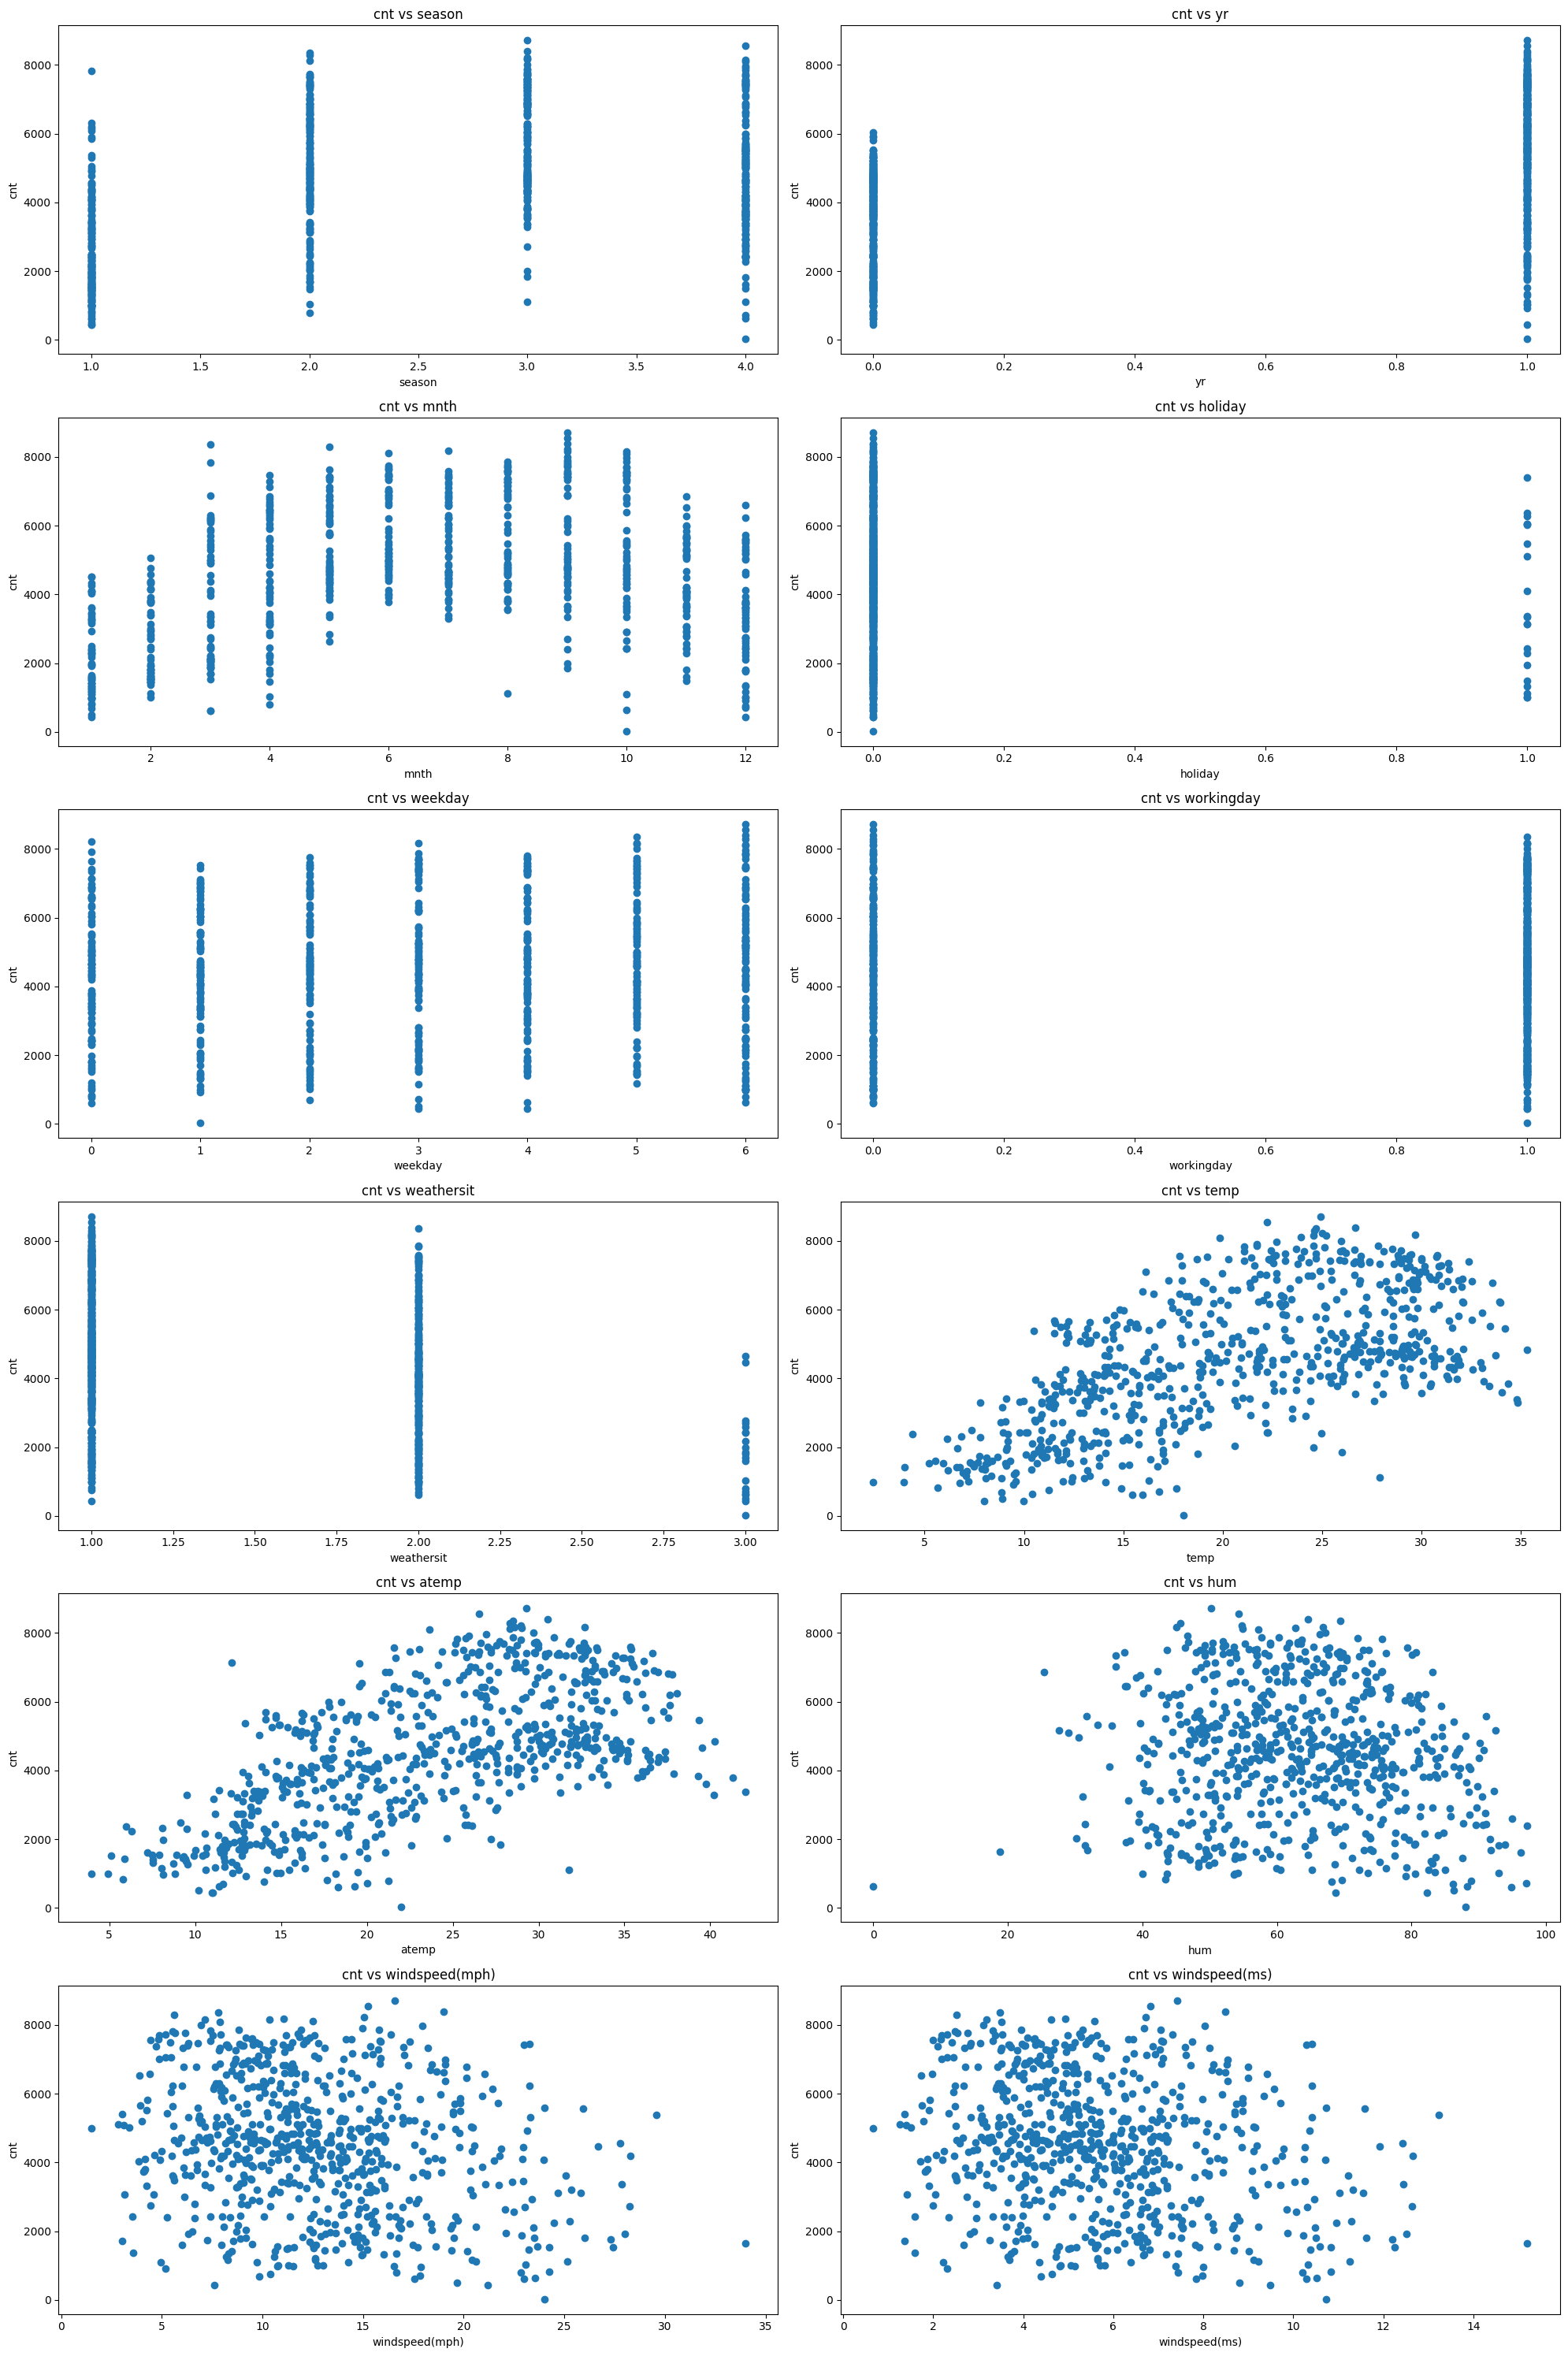

In [155]:
# Put you code here

# Ознаки, які не включають cnt
features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

# Побудова графіків залежностей
plt.figure(figsize=(20, 30))  # Задати розмір для усіх графіків

for i, feature in enumerate(features):
    plt.subplot(6, 2, i+1)  # Задати позицію для кожного графіка
    plt.scatter(df[feature], df['cnt'])  # Побудова графіка залежності
    plt.title(f'cnt vs {feature}')  # Заголовок для кожного графіка
    plt.xlabel(feature)  # Позначення осі X
    plt.ylabel('cnt')  # Позначення осі Y

plt.tight_layout()  # Прибираємо прогалини між графіками
plt.show()  # Відображення графіків

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця? Залежність кількості прокатів від місяця може бути симетричною, але її характер може бути нелінійним.
2. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно. Ознаки, від яких кількість прокатів залежить лінійно, можуть бути:
season: Залежність кількості прокатів може бути лінійною від сезону, оскільки відомо, що кількість прокатів може змінюватися в залежності від пори року.
holiday: Якщо вважати, що на свята кількість прокатів може зростати, то залежність може бути лінійною.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [156]:
# Put your code here

# Видалення останньої ознаки, оскільки вона є цільовою ознакою
features = df.columns[:-1]

# Обчислення кореляцій між всіма ознаками, окрім останньої, з останньою
correlations = df[features].corrwith(df['cnt'])

print(correlations)

# Обчислення кореляцій, включаючи останню ознаку (cnt)
correlations = df.corrwith(df['cnt'])

print('Обчислення кореляцій, включаючи останню ознаку (cnt)')
print(correlations)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64
Обчислення кореляцій, включаючи останню ознаку (cnt)
season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
cnt               1.000000
dtype: float64


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [157]:
# Put your code here
# Вибір ознак, які потрібно обчислити кореляції
selected_features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

# Вибір тільки тих ознак, які потрібно обчислити кореляції
df_selected = df[selected_features]

# Обчислення попарних кореляцій
correlation_matrix = df_selected.corr()

print(correlation_matrix)

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [158]:
# Put your code here
# Обчислення середніх ознак
mean_values = df.mean()

print(mean_values)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [159]:
from sklearn.preprocessing import scale # type: ignore
from sklearn.utils import shuffle # type: ignore

In [160]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [161]:
from sklearn.linear_model import LinearRegression # type: ignore

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [162]:
# Put your code here
# Створення об'єкту лінійного регресора
regressor = LinearRegression()

# Навчання моделі на всіх даних
regressor.fit(X, y)

# Виведення вагів моделі
for feature, weight in zip(df.columns[:-1], regressor.coef_):
    print(f"{feature}: {weight}")

season: 570.863641661725
yr: 1021.9604245185086
mnth: -141.3006331900142
holiday: -86.75760471139698
weekday: 137.2272583151452
workingday: 56.38980357474366
weathersit: -330.2271825899341
temp: 367.4799030832653
atemp: 585.5521797658965
hum: -145.6155228231448
windspeed(mph): 12454356291009.727
windspeed(ms): -12454356291208.188


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [163]:
# Put your code here
from sklearn.linear_model import Lasso, Ridge

# Створення об'єктів лінійних регресорів з L1 та L2 регуляризацією
lasso_regressor = Lasso()
ridge_regressor = Ridge()

# Навчання моделей на всіх даних
lasso_regressor.fit(X, y)
ridge_regressor.fit(X, y)

# Виведення вагів моделей
print("Ваги моделі з L1-регуляризацією (Lasso):")
for feature, weight in zip(df.columns[:-1], lasso_regressor.coef_):
    print(f"{feature}: {weight}")

print("\nВаги моделі з L2-регуляризацією (Ridge):")
for feature, weight in zip(df.columns[:-1], ridge_regressor.coef_):
    print(f"{feature}: {weight}")

Ваги моделі з L1-регуляризацією (Lasso):
season: 560.2416160308861
yr: 1019.4634940657196
mnth: -128.73062703678696
holiday: -86.15278133371106
weekday: 137.34789390496314
workingday: 55.21237064135668
weathersit: -332.3698569623487
temp: 376.3632362096943
atemp: 576.530793504555
hum: -144.12915500348583
windspeed(mph): -197.1396894024843
windspeed(ms): -2.8051404183533485e-08

Ваги моделі з L2-регуляризацією (Ridge):
season: 563.0645722520164
yr: 1018.9483787875275
mnth: -131.87332028247582
holiday: -86.74609799709243
weekday: 138.00511117871926
workingday: 55.90311037506429
weathersit: -332.34978849907236
temp: 386.45788919189926
atemp: 566.3470470600766
hum: -145.0713272986732
windspeed(mph): -99.25944108174306
windspeed(ms): -99.25944115438946


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [164]:
# Put your code here
from sklearn.linear_model import Ridge

# Створення об'єкту лінійного регресора з L2-регуляризацією (Ridge)
ridge_regressor = Ridge()

# Навчання моделі на всіх даних
ridge_regressor.fit(X, y)

# Виведення вагів моделі
print("Ваги моделі з L2-регуляризацією (Ridge):")
for feature, weight in zip(df.columns[:-1], ridge_regressor.coef_):
    print(f"{feature}: {weight}")

Ваги моделі з L2-регуляризацією (Ridge):
season: 563.0645722520164
yr: 1018.9483787875275
mnth: -131.87332028247582
holiday: -86.74609799709243
weekday: 138.00511117871926
workingday: 55.90311037506429
weathersit: -332.34978849907236
temp: 386.45788919189926
atemp: 566.3470470600766
hum: -145.0713272986732
windspeed(mph): -99.25944108174306
windspeed(ms): -99.25944115438946


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [165]:
import numpy as np
from sklearn.linear_model import Lasso, Ridge

# Визначення ряду значень коефіцієнта регуляризації alpha
alphas = np.arange(1, 500, 50)

# Списки для зберігання вагів моделей
coefs_lasso = []
coefs_ridge = []

# Навчання моделей з різними значеннями alpha
for alpha in alphas:
    # Навчання моделі Lasso
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X, y)
    coefs_lasso.append(lasso_regressor.coef_)
    
    # Навчання моделі Ridge
    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X, y)
    coefs_ridge.append(ridge_regressor.coef_)

# Конвертація списків вагів у numpy масиви
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

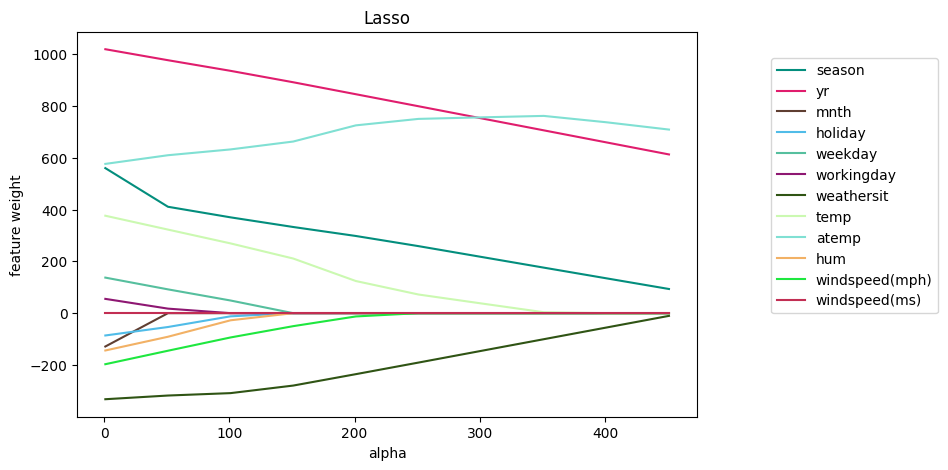

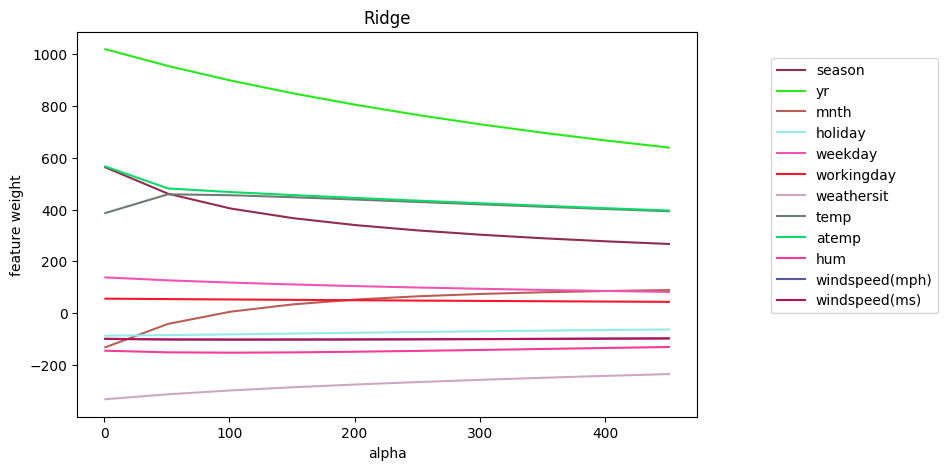

In [166]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha? Якщо Lasso зменшує ваги більш ніж Ridge, то Lasso агресивніше зменшує ваги при одному й тому самому alpha. Якщо Ridge зменшує ваги більш ніж Lasso, то Ridge агресивніше зменшує ваги при одному й тому самому alpha.
2. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається. Якщо alpha дуже велике, то Lasso намагатиметься обнулити ваги, що може призвести до виключення ознак. Це стає очевидним, коли ми бачимо, що деякі ваги стають близько нуля.
3. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$. Lasso може виключити одну з ознак windspeed, якщо alpha достатньо велике. Однак, це залежить від того, які саме значення alpha ви використовуєте. Ridge не може виключити ознаку, оскільки він завжди зменшує ваги, не обнулюючи їх.
4. Який із регуляризаторів підійде для відбору неінформативних ознак? Lasso може бути корисним для відбору неінформативних ознак, оскільки він може обнулити ваги неінформативних ознак.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [167]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

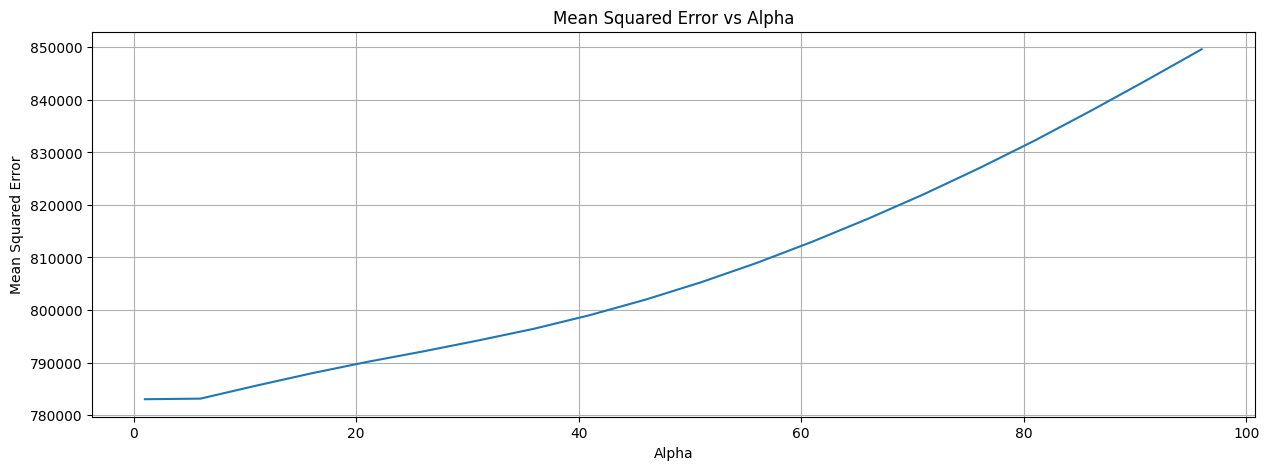

Обране alpha: 1
season: 560.2416160308861
yr: 1019.4634940657196
mnth: -128.73062703678696
holiday: -86.15278133371106
weekday: 137.34789390496314
workingday: 55.21237064135668
weathersit: -332.3698569623487
temp: 376.3632362096943
atemp: 576.530793504555
hum: -144.12915500348583
windspeed(mph): -197.1396894024843
windspeed(ms): -2.8051404183533485e-08


In [168]:
from sklearn.linear_model import LassoCV # type: ignore
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()
    
# Визначення ряду значень alpha
alphas = np.arange(1, 100, 5)

# Навчання моделі LassoCV з різними значеннями alpha
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso_cv.fit(X, y)

# Обчислення середнього MSE для кожного значення alpha
mse_scores = np.mean(lasso_cv.mse_path_, axis=1)

# Створення списку пар alpha та MSE
alpha_mse = list(zip(lasso_cv.alphas_, mse_scores))

# Відображення графіку залежності MSE від alpha
create_plot(alpha_mse, "Mean Squared Error vs Alpha", "Alpha", "Mean Squared Error")

# Виведення вибраного alpha
print(f"Обране alpha: {lasso_cv.alpha_}")

# Виведення пар "ознака-коефіцієнт" для навченого вектора коефіцієнтів
for feature, coef in zip(df.columns[:-1], lasso_cv.coef_):
    print(f"{feature}: {coef}")

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Alpha, що відповідають мінімумам MSE на кожному розбитті:
[ 1 11  1 26 21]


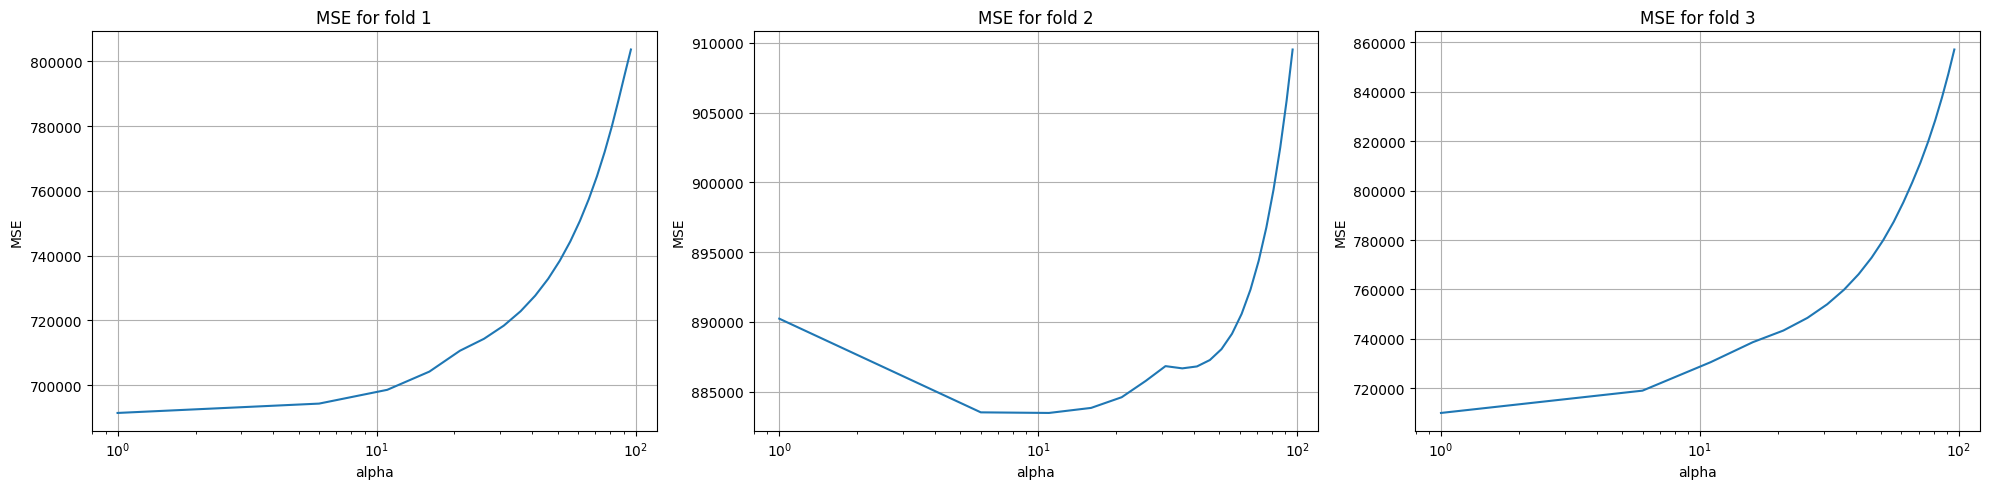

In [169]:
# Put your code here
import matplotlib.pyplot as plt

# Виведення значень alpha, що відповідають мінімумам MSE на кожному розбитті
min_mse_indices = np.argmin(lasso_cv.mse_path_, axis=0)
min_alphas = lasso_cv.alphas_[min_mse_indices]
print("Alpha, що відповідають мінімумам MSE на кожному розбитті:")
print(min_alphas)

# Візуалізація стовпців mse_path_
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs.flatten()):
    ax.plot(lasso_cv.alphas_, lasso_cv.mse_path_[:, i])
    ax.set_xscale('log')
    ax.set_xlabel('alpha')
    ax.set_ylabel('MSE')
    ax.set_title(f'MSE for fold {i+1}')
    ax.grid(True)

plt.tight_layout()
plt.show()

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

4 найбільш корисні ознаки:
temp
season
atemp
yr


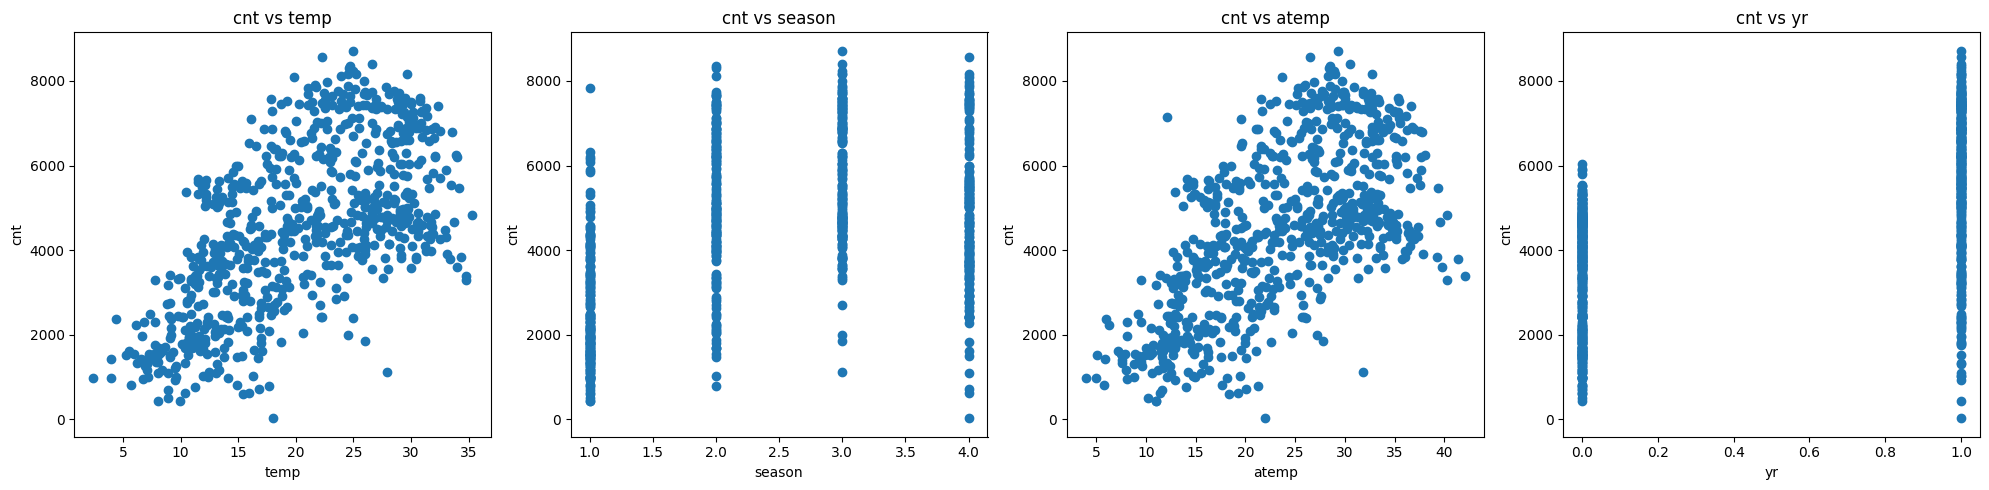

In [174]:
# Проаналізуємо найбільш корисні ознаки, які мають найбільші коефіцієнти у нашій моделі Lasso 
# з використанням LassoCV.
# Вибираємо 4 найбільш корисні ознаки
top_features = np.argsort(np.abs(lasso_cv.coef_))[-4:]
top_feature_names = df.columns[top_features]

print("4 найбільш корисні ознаки:")
for feature in top_feature_names:
    print(feature)
    
# Тепер ми можемо подивитися на графіки залежностей cnt від цих ознак.
plt.figure(figsize=(20, 5))

for i, feature in enumerate(top_feature_names):
    plt.subplot(1, 4, i+1)
    plt.scatter(df[feature], df['cnt'])
    plt.title(f'cnt vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('cnt')

plt.tight_layout()
plt.show()

# Зростаючу лінійну залежність cnt від цих ознак може бути бачити з графіків, 
# але це не означає, що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди. 
# Це залежить від багатьох факторів, таких як інші ознаки, які враховуються в моделі, 
# а також взаємозв'язки між цими ознаками. Наприклад, якщо одна з цих ознак є взаємозв'язком 
# з іншими ознаками, які враховуються в моделі, то зміна значення цієї ознаки може мати 
# інший ефект.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

3 найбільш негативні ознаки:
windspeed(ms)
workingday
holiday


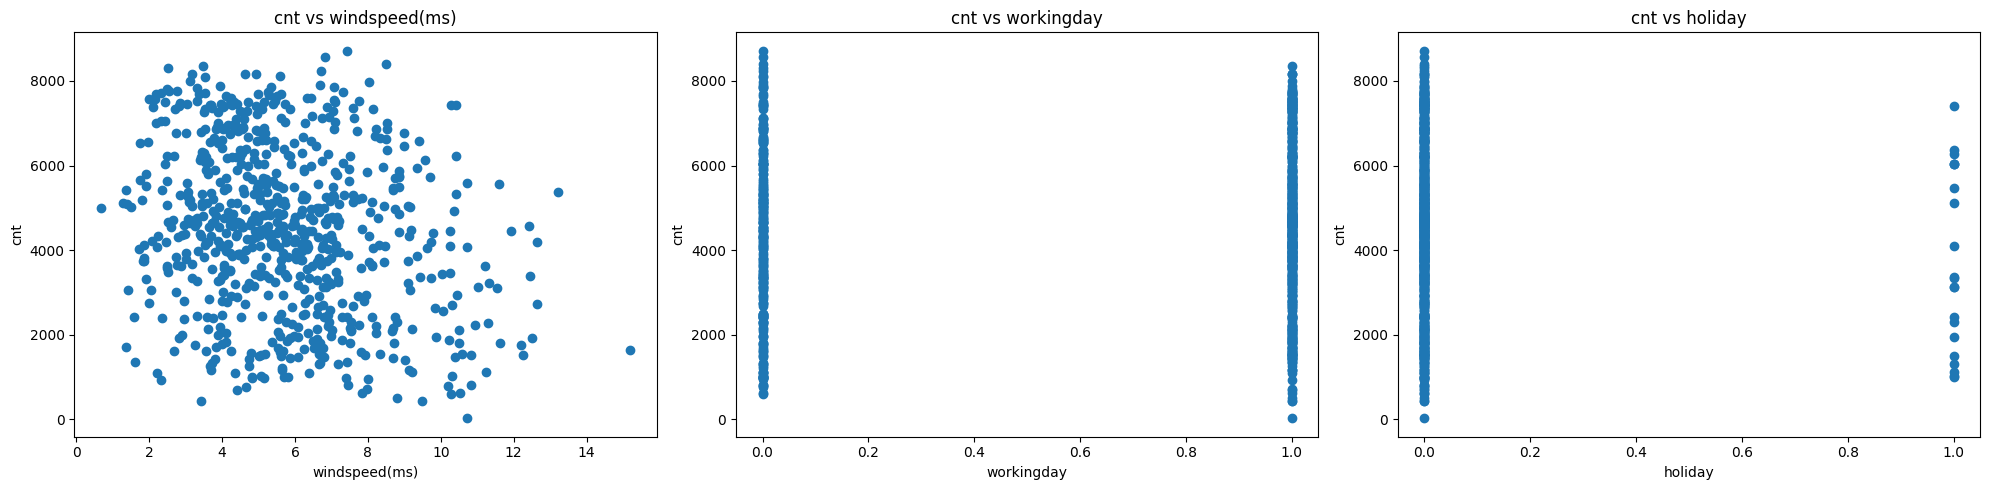

In [175]:
# Проаналізуємо найбільш негативні ознаки, які мають найменші коефіцієнти у нашій моделі Lasso 
# з використанням LassoCV.
# Вибираємо 3 найбільш негативні ознаки
bottom_features = np.argsort(np.abs(lasso_cv.coef_))[:3]
bottom_feature_names = df.columns[bottom_features]

print("3 найбільш негативні ознаки:")
for feature in bottom_feature_names:
    print(feature)
    
# Тепер ми можемо подивитися на графіки залежностей cnt від цих ознак.
plt.figure(figsize=(20, 5))

for i, feature in enumerate(bottom_feature_names):
    plt.subplot(1, 3, i+1)
    plt.scatter(df[feature], df['cnt'])
    plt.title(f'cnt vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('cnt')

plt.tight_layout()
plt.show()

#  Бачимо лінійну залежність, що зменшується, це може означати, що чим більша величина цих ознак, 
# тим менше людей захочуть взяти велосипеди. Це залежить від багатьох факторів, таких як інші 
# ознаки, які враховуються в моделі, а також взаємозв'язки між цими ознаками. Наприклад, 
# якщо одна з цих ознак є взаємозв'язком з іншими ознаками, які враховуються в моделі, 
# то зміна значення цієї ознаки може мати інший ефект.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

Ознаки з коефіцієнтами, близькими до нуля:
windspeed(ms)


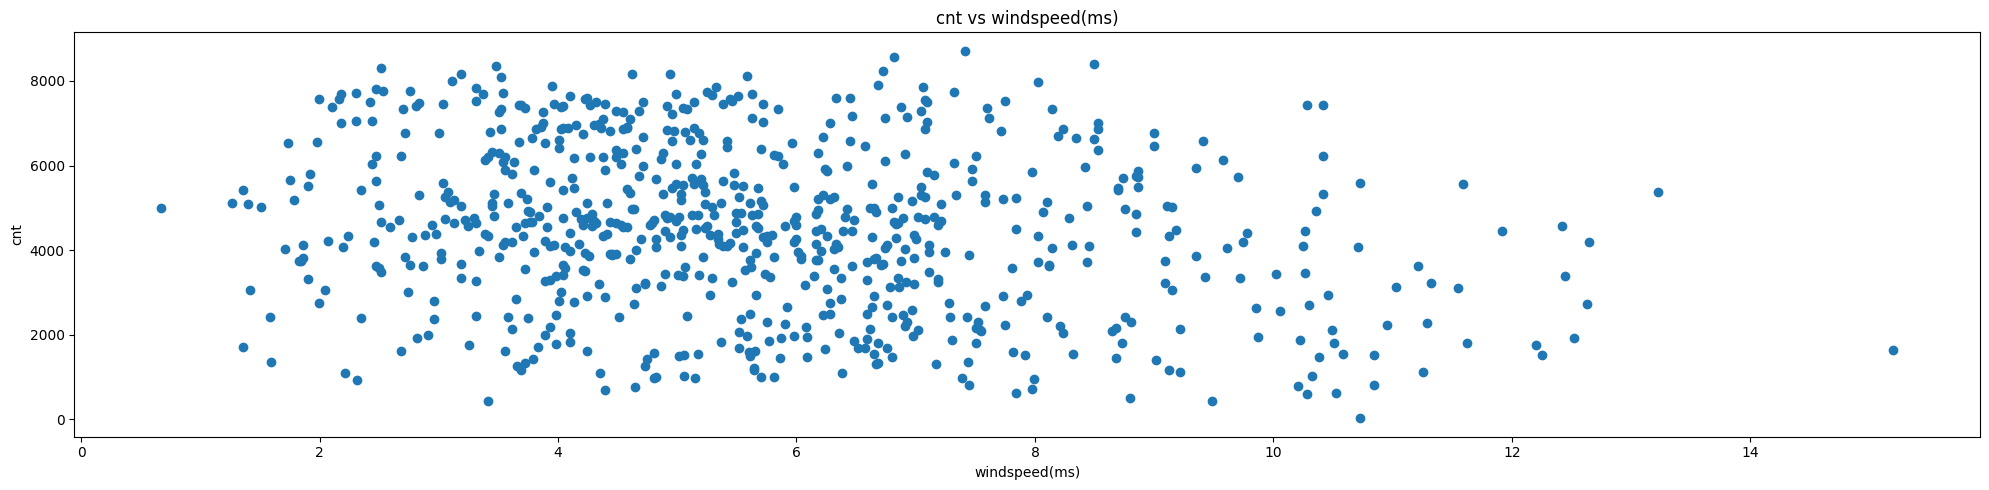

In [176]:
# Виберемо ознаки з коефіцієнтами, близькими до нуля (< 1e-3).

near_zero_features = np.where(np.abs(lasso_cv.coef_) < 1e-3)[0]
near_zero_feature_names = df.columns[near_zero_features]

print("Ознаки з коефіцієнтами, близькими до нуля:")
for feature in near_zero_feature_names:
    print(feature)
    
# Тепер ми можемо подивитися на графіки залежностей cnt від цих ознак.
plt.figure(figsize=(20, 5))

for i, feature in enumerate(near_zero_feature_names):
    plt.subplot(1, len(near_zero_feature_names), i+1)
    plt.scatter(df[feature], df['cnt'])
    plt.title(f'cnt vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('cnt')

plt.tight_layout()
plt.show()

# Якщо модель виключила їх із моделі, це означає, що вони не впливають на попит на велосипеди. 
# Це може бути зроблено для того, щоб уникнути перенавчання моделі, яке може статися, 
# якщо включити до моделі ознаки, які не мають значущого впливу на результат. Однак, 
# це не означає, що вони ніяк не впливають на попит на велосипеди, оскільки інші ознаки 
# можуть іншим чином взаємодіяти з цими ознаками.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.